In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import utils as u
import pandas as pd
import scipy.stats as ss
import seaborn as sns

## added 1 on calibrated profile 

In [2]:
#calibrated (subtracted mean) profile txt created from notebook J0332+5434
prof = np.loadtxt('J0332_profile.txt')
prof += 1 #add one so when taking cdf, the negative values don't make it look weird
nprofs = len(prof)

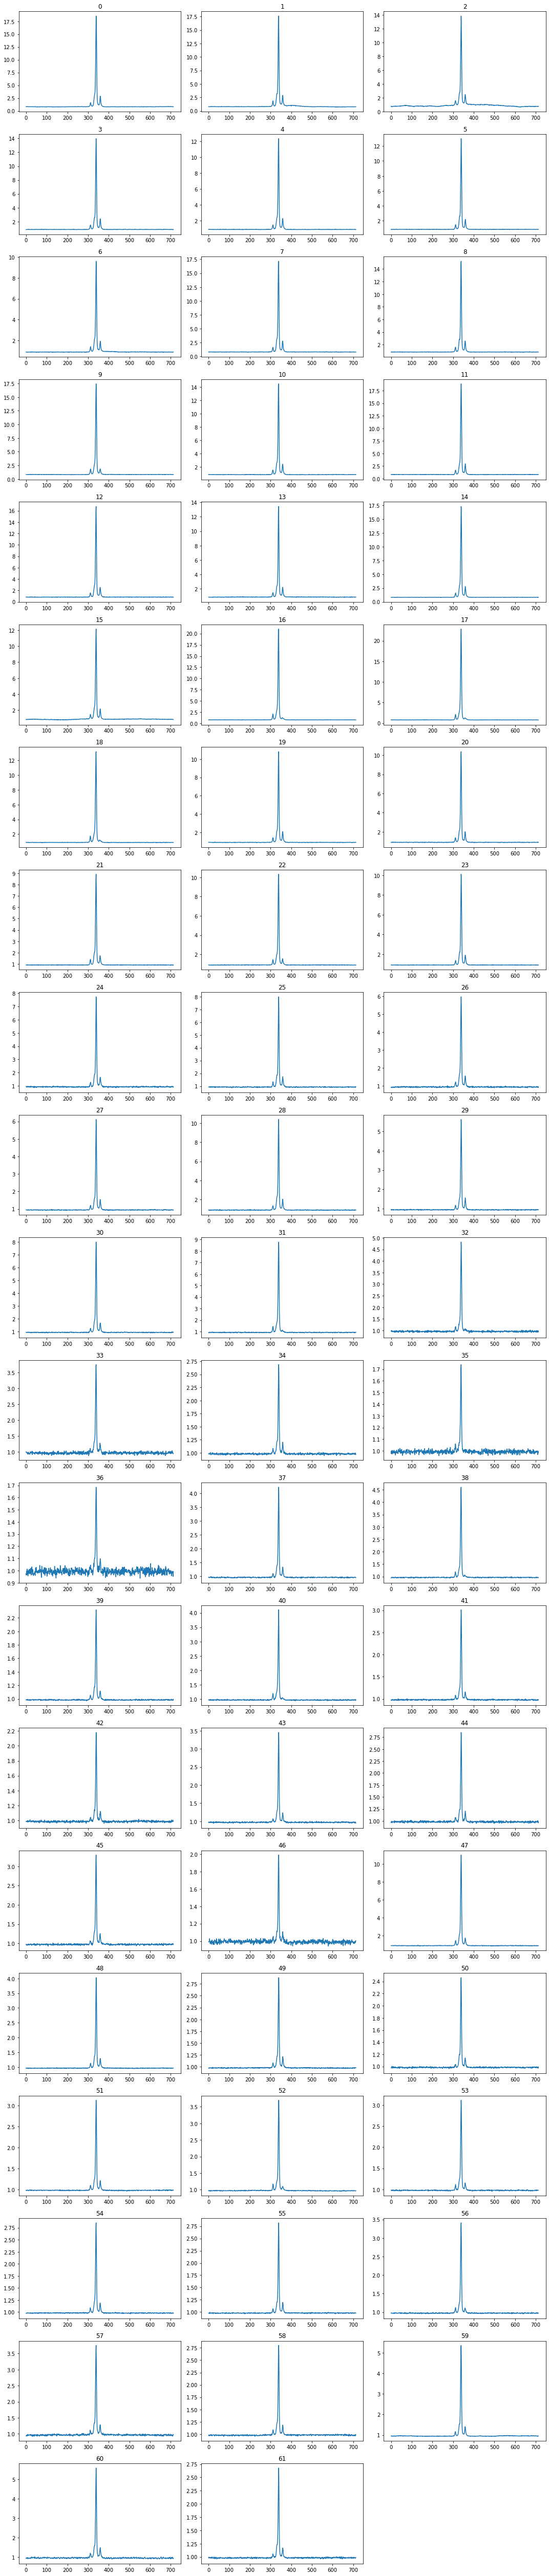

In [4]:
#pick index = 0 as "template"
u.gridplot(prof,3,hist=False)

# 1000 sim on index 0 profile, perform ks test against ind0 and plot D-statistic

In [5]:
#here null is cdf of profile index 0
null = np.cumsum(prof[0]) 
null = null / np.sum(null)#normalize
np.savetxt('./R_analysis/null.txt',null)

In [6]:
#add noise to 1000 copies of null profile (index 0), take cdf and store as 2d array 1000 x nbins
nsims = 1000
nbins = prof.shape[1]
sigma = .5
sim_cdf = np.zeros((nsims,nbins))

for i in range(nsims):
    noise_prof = prof[0] + np.random.randn(nbins)*sigma #add noise
    cumsum = np.cumsum(noise_prof) #compute cdf
    sim_cdf[i] = cumsum / np.sum(cumsum) #normalize, add to sim_cdf
    

In [7]:
#save simulated cdf 2D array
np.savetxt('./R_analysis/sim_cdf.txt',sim_cdf)

In [8]:
#load D-values from ks test between reference template and simulated templates
D_sim = np.loadtxt('./R_analysis/sim_Dvalues.txt')

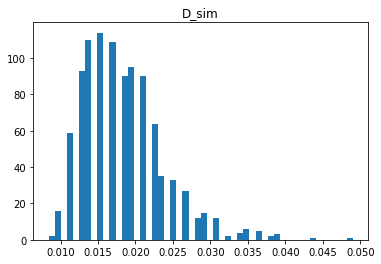

In [9]:
plt.hist(D_sim,bins=50)
plt.title("D_sim")
plt.show()

/Users/MYK/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


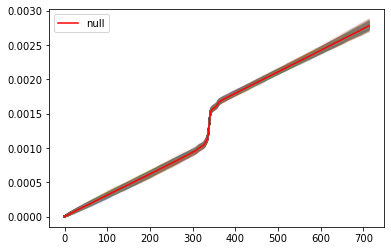

In [10]:
for i in range(nsims):
    plt.plot(sim_cdf[i], alpha=.1)
plt.plot(null, 'r', label='null')
plt.legend()
plt.show()

# create cdf of other profiles (ind!=0), ks test against ind0 prof, plot D statistic

In [11]:
#create 2D array to store cdf of other profiles
cdf = np.zeros((len(prof)-1,nbins))

for i in range(len(cdf)):
    cumsum = np.cumsum(prof[i+1]) #+1 to skip reference profile at index 0
    cdf[i] = cumsum / np.sum(cumsum) #normalize

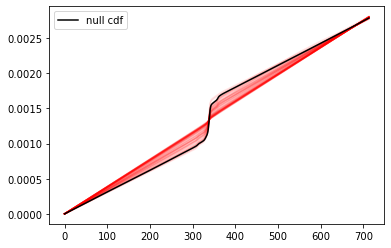

In [12]:
for i in range(len(cdf)):
    plt.plot(cdf[i],'r', alpha=.1)
plt.plot(null,'k', label='null cdf')
plt.legend()
plt.show()

In [13]:
#save cdfs
np.savetxt('./R_analysis/cdf.txt',cdf)

In [3]:
#import D statistic from ks test between null cdf and other cdfs
D_real = np.loadtxt('./R_analysis/real_Dvalues.txt')

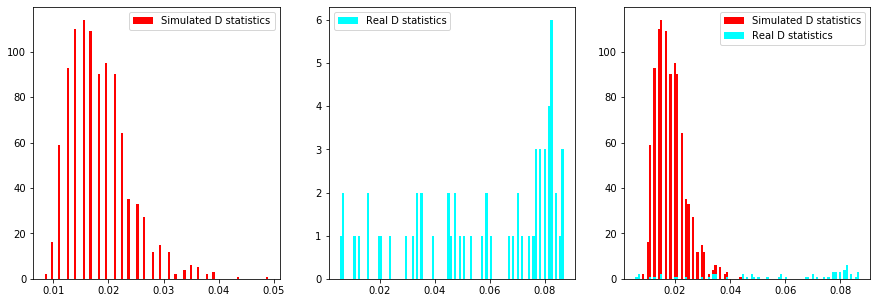

In [15]:
min_bin = np.min([np.min(D_sim), np.min(D_real)])
max_bin = np.max([np.max(D_sim), np.max(D_real)])
bins = np.linspace(min_bin, max_bin, 100)

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

ax1.hist(D_sim, bins=100, color='r', label='Simulated D statistics')
ax1.legend()

ax2.hist(D_real, bins=100, color='cyan', label='Real D statistics')
ax2.legend()

ax3.hist(D_sim, bins=bins, color='r', label='Simulated D statistics')
ax3.hist(D_real, bins=bins, color='cyan', label='Real D statistics')
ax3.legend()
plt.show()

# Plot D-statistic as function of epoch

In [4]:
#Set critical value of D statistic as .04.
D_crit = .04

#import MJD
mjd_arr = np.loadtxt('J0332_MJD.txt')
mjd_arr = mjd_arr[1:] #remove first element, because that is MJD of refernce profile

In [5]:
#create pandas object
data = np.vstack((mjd_arr, D_real))
df = pd.DataFrame(data, index=['MJD', 'D_statistic']).T

/Users/MYK/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


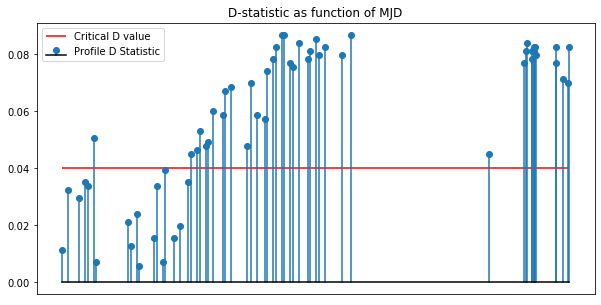

In [8]:
#plot D-statistic as function of MJD
fig = plt.figure(figsize=(10,5))
plt.stem(df['MJD'], df['D_statistic'], label='Profile D Statistic', basefmt='k')
plt.hlines(y=D_crit, xmin=mjd_arr[0], xmax=mjd_arr[-1], color='r', label='Critical D value')
plt.legend()
plt.title('D-statistic as function of MJD')
plt.xticks([])
plt.show()

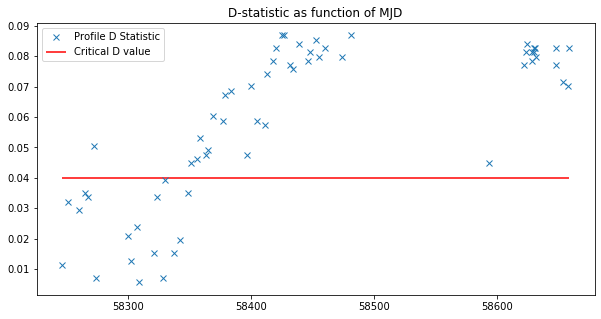

In [18]:
#plot D-statistic as function of MJD
fig = plt.figure(figsize=(10,5))
plt.plot(df['MJD'], df['D_statistic'], 'x', label='Profile D Statistic')
plt.hlines(y=D_crit, xmin=mjd_arr[0], xmax=mjd_arr[-1], color='r', label='Critical D value')
plt.legend()
plt.title('D-statistic as function of MJD')
plt.show()

In [19]:
mask = df['D_statistic'] > .04
mode_change = df['MJD'][mask]
mode_change.head()

5     58272.0
18    58351.0
19    58356.0
20    58358.0
21    58363.0
Name: MJD, dtype: float64

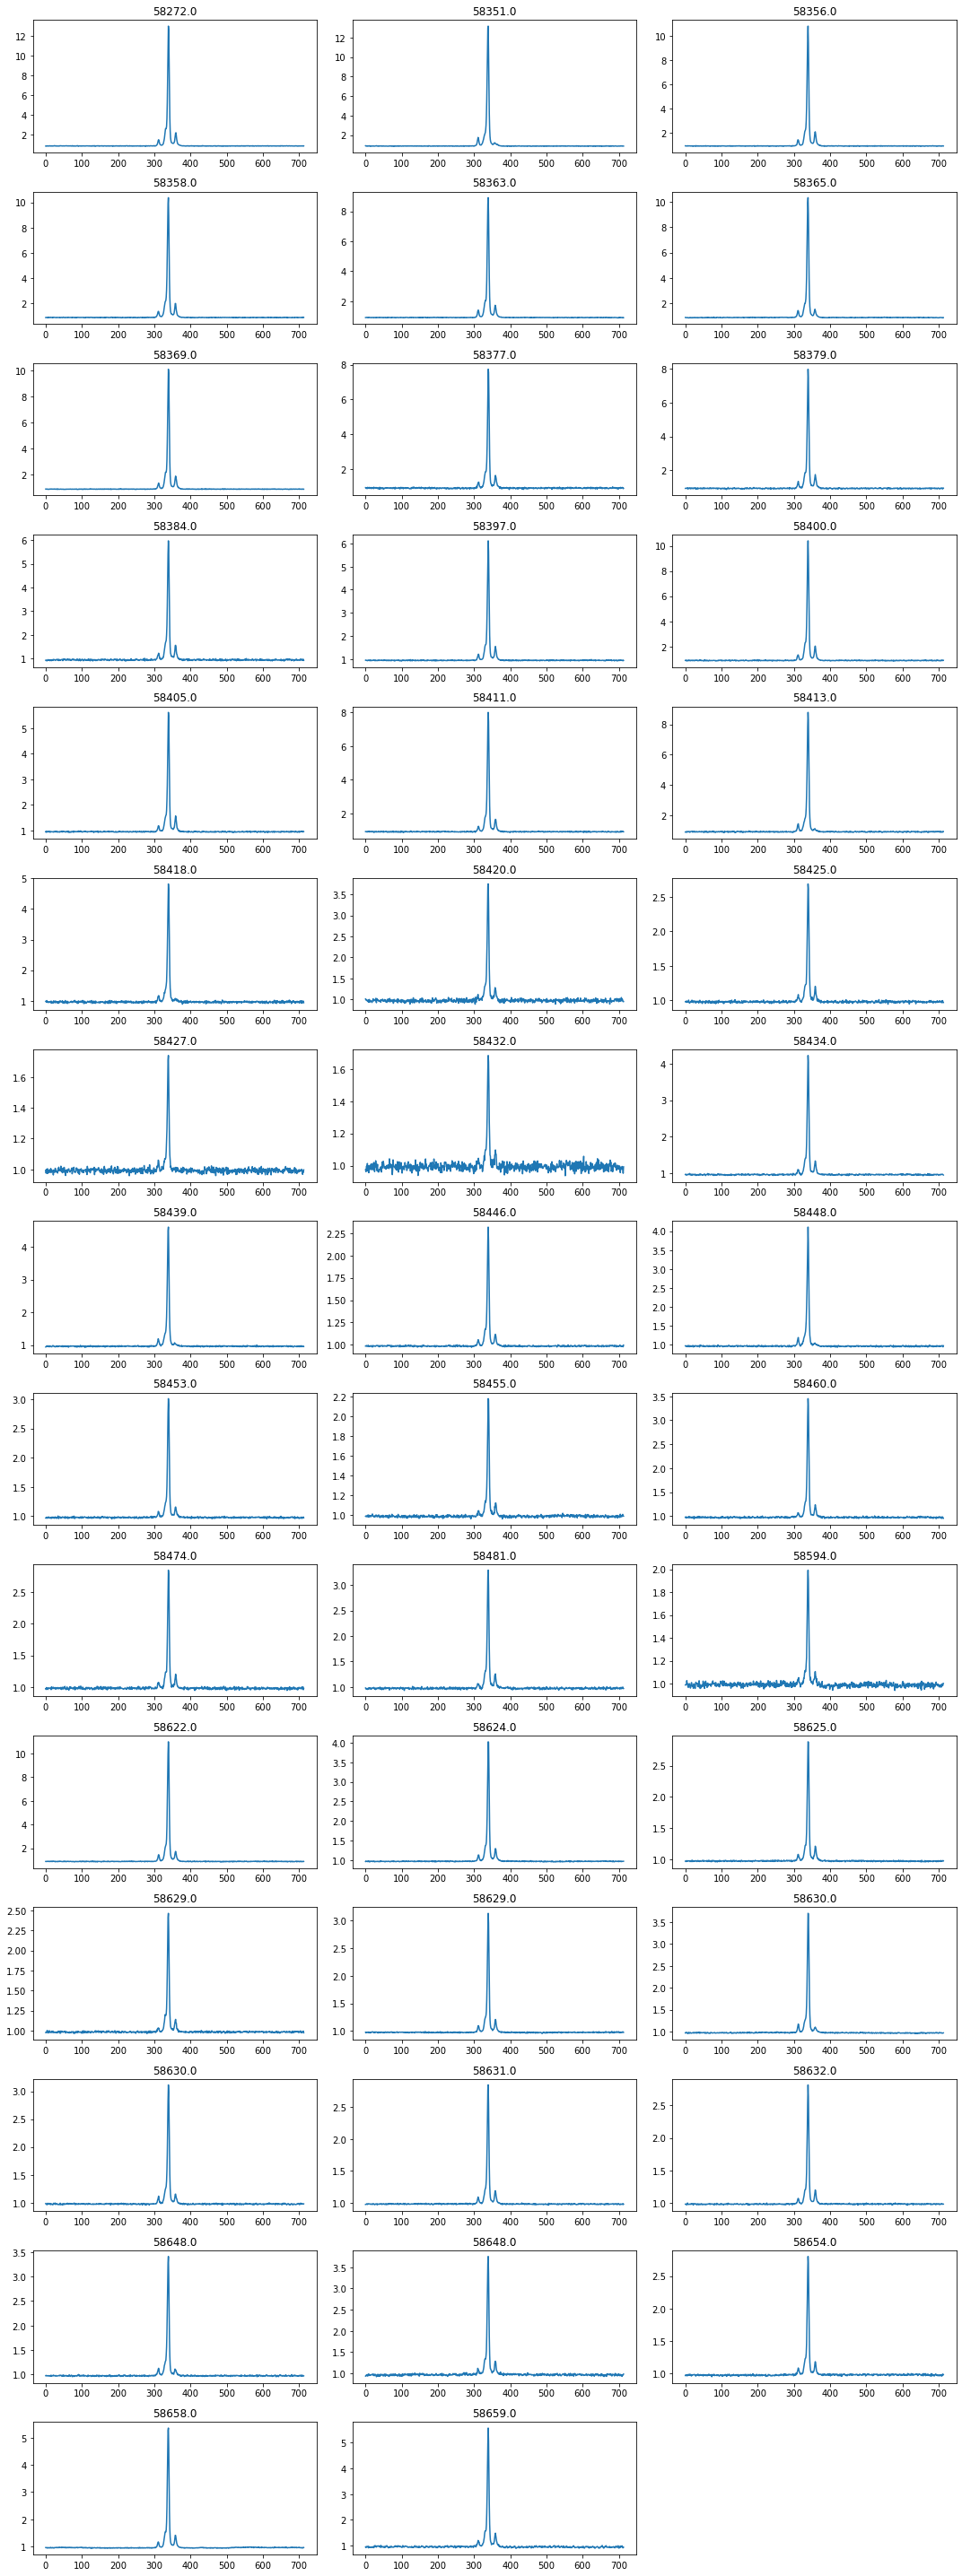

In [20]:
fig = plt.figure(figsize=(15,40))
for i, pd_ind in enumerate(mode_change.index):
    ax = fig.add_subplot(len(mode_change)//3 + 1, 3, i+1)
    ax.plot(prof[pd_ind])
    ax.set_title(mode_change.loc[pd_ind])
plt.tight_layout()
plt.show()

In [21]:
df['mode'] = [1 if D > .04 else 0 for D in df.D_statistic]
df.head()

,MJD,D_statistic,mode
0,58246.0,0.011204,0
1,58251.0,0.032213,0
2,58260.0,0.029412,0
3,58265.0,0.035014,0
4,58267.0,0.033613,0


In [86]:
def snr(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    
    return np.where(sd == 0, 0, m/sd)

In [96]:
snr_arr = np.zeros(len(prof)-1)#exclude first reference profile
for i in range(len(prof)-1):
    snr_arr[i] = snr(prof[i+1])

df['crude_snr'] = snr_arr

In [97]:
df.head()

,MJD,D_statistic,mode,snr,crude_snr
0,58246.0,0.011204,0,0.791871,0.791871
1,58251.0,0.032213,0,1.012998,1.012998
2,58260.0,0.029412,0,1.023455,1.023455
3,58265.0,0.035014,0,1.139221,1.139221
4,58267.0,0.033613,0,1.101487,1.101487


Text(0.5, 1.0, 'Average Crude SNR 1.788947')

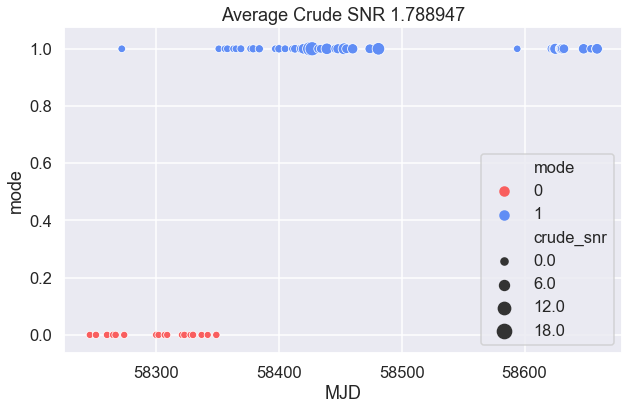

In [104]:
sns.set(context='talk', style='darkgrid')

fig = plt.figure(figsize=(10,6))
#cmap = sns.color_palette(palette='Set3', n_colors=2)
cmap = sns.color_palette(['#F95E5E', '#608DF5'])
ax = sns.scatterplot(x='MJD', y='mode', data=df, hue='mode', size='crude_snr', sizes=(50,200), \
                     palette=cmap)
ax.set_title('Average Crude SNR %f' % snr(np.average(prof,axis=0)))
